In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%shell
pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [3]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

In [4]:
class charDataset(object):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "image"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "label"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "image", self.imgs[idx])

        mask_path = os.path.join(self.root, "label", self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        w, h = img.size
        img = img.convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background

        # get bounding box coordinates for each mask
        num_objs = 0
        boxes = []
        with open(mask_path) as f:
          for line in f:
            num_objs += 1
            xc, yc, ws, hs = list(map(float, line.split()[1:]))
            x1 = (xc-ws/2)*w
            y1 = (yc-hs/2)*h
            boxes.append([x1, y1, x1+ws*w, y1+hs*h])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        # masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        # target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [5]:
dataset = charDataset('/content/drive/My Drive/bbox_data/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=720x672 at 0x7F52F6BF0CC0>,
 {'area': tensor([2733.2888, 2761.7019, 2847.5745, 2936.4644, 2954.2378, 2948.5227,
          2619.9570, 2594.8779, 2968.9993, 2716.1492]),
  'boxes': tensor([[182.0718, 227.0919, 231.0758, 282.8687],
          [257.3703, 226.2951, 307.9679, 280.8767],
          [328.6856, 225.0993, 380.4784, 280.0794],
          [408.3668, 223.1073, 458.1676, 282.0714],
          [478.0875, 222.3110, 530.6771, 278.4863],
          [183.2670, 319.1238, 234.6614, 376.4943],
          [257.7690, 315.5378, 307.9682, 367.7290],
          [336.6534, 313.5457, 385.2589, 366.9322],
          [403.9844, 311.9519, 455.3788, 369.7209],
          [481.2752, 311.1556, 530.6776, 366.1357]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])})

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
 
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [8]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be37608 version check against PyTorch's CUDA version


In [9]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [11]:
# use our dataset and defined transformations
dataset = charDataset('/content/drive/My Drive/bbox_data/', get_transform(train=True))
dataset_test = charDataset('/content/drive/My Drive/bbox_data/', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-20])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-20:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [13]:
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch: [0]  [ 0/39]  eta: 0:02:02  lr: 0.000136  loss: 2.2552 (2.2552)  loss_classifier: 0.7784 (0.7784)  loss_box_reg: 0.9200 (0.9200)  loss_objectness: 0.4848 (0.4848)  loss_rpn_box_reg: 0.0720 (0.0720)  time: 3.1498  data: 1.9951  max mem: 2711
Epoch: [0]  [10/39]  eta: 0:00:27  lr: 0.001451  loss: 1.5872 (1.7236)  loss_classifier: 0.5451 (0.5870)  loss_box_reg: 0.8536 (0.8074)  loss_objectness: 0.1855 (0.2711)  loss_rpn_box_reg: 0.0390 (0.0581)  time: 0.9338  data: 0.2101  max mem: 3383
Epoch: [0]  [20/39]  eta: 0:00:16  lr: 0.002765  loss: 1.2758 (1.4132)  loss_classifier: 0.3406 (0.4343)  loss_box_reg: 0.6698 (0.7146)  loss_objectness: 0.1538 (0.2125)  loss_rpn_box_reg: 0.0421 (0.0518)  time: 0.7413  data: 0.0425  max mem: 3422
Epoch: [0]  [30/39]  eta: 0:00:08  lr: 0.004080  loss: 0.9170 (1.2046)  loss_classifier: 0.2351 (0.3547)  loss_box_reg: 0.5975 (0.6390)  loss_objectness: 0.0464 (0.1543)  loss_rpn_box_reg: 0.0460 (0.0566)  time: 0.9144  data: 0.2288  max mem: 3422
Epoch: [

save model

In [14]:
PATH = '/content/drive/My Drive/bbox_data/pytorchmodel/pytorchmodel'
torch.save(model, PATH)

load model

In [15]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model = torch.load(PATH)

In [35]:
# pick one image from the test set
image, _ = dataset_test[12]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([image.to(device)])

In [23]:
prediction[0]

{'boxes': tensor([[181.4242, 226.8382, 230.5685, 281.8007],
         [404.9807, 313.5880, 454.7940, 367.8686],
         [481.5265, 307.8688, 531.1865, 366.4751],
         [182.5437, 316.9308, 234.5728, 375.7375],
         [335.3685, 315.5632, 384.4826, 366.4377],
         [259.2627, 314.3224, 308.6779, 369.5622],
         [406.5641, 222.3305, 458.0454, 278.8973],
         [328.9115, 224.4350, 381.0605, 278.6705],
         [480.1043, 219.8523, 531.4569, 277.9929],
         [255.5146, 224.7426, 306.0746, 280.5632],
         [236.7040, 381.6164, 292.8232, 431.2470],
         [357.4012, 372.3559, 475.5853, 440.6331],
         [184.9334, 222.7011, 306.0024, 282.1403],
         [424.0133, 305.5628, 534.2655, 367.8189],
         [419.5007, 216.2776, 532.1762, 277.9840]], device='cuda:0'),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([0.9966, 0.9953, 0.9953, 0.9951, 0.9949, 0.9948, 0.9944, 0.9937, 0.9935,
         0.9930, 0.5378, 0.4086, 

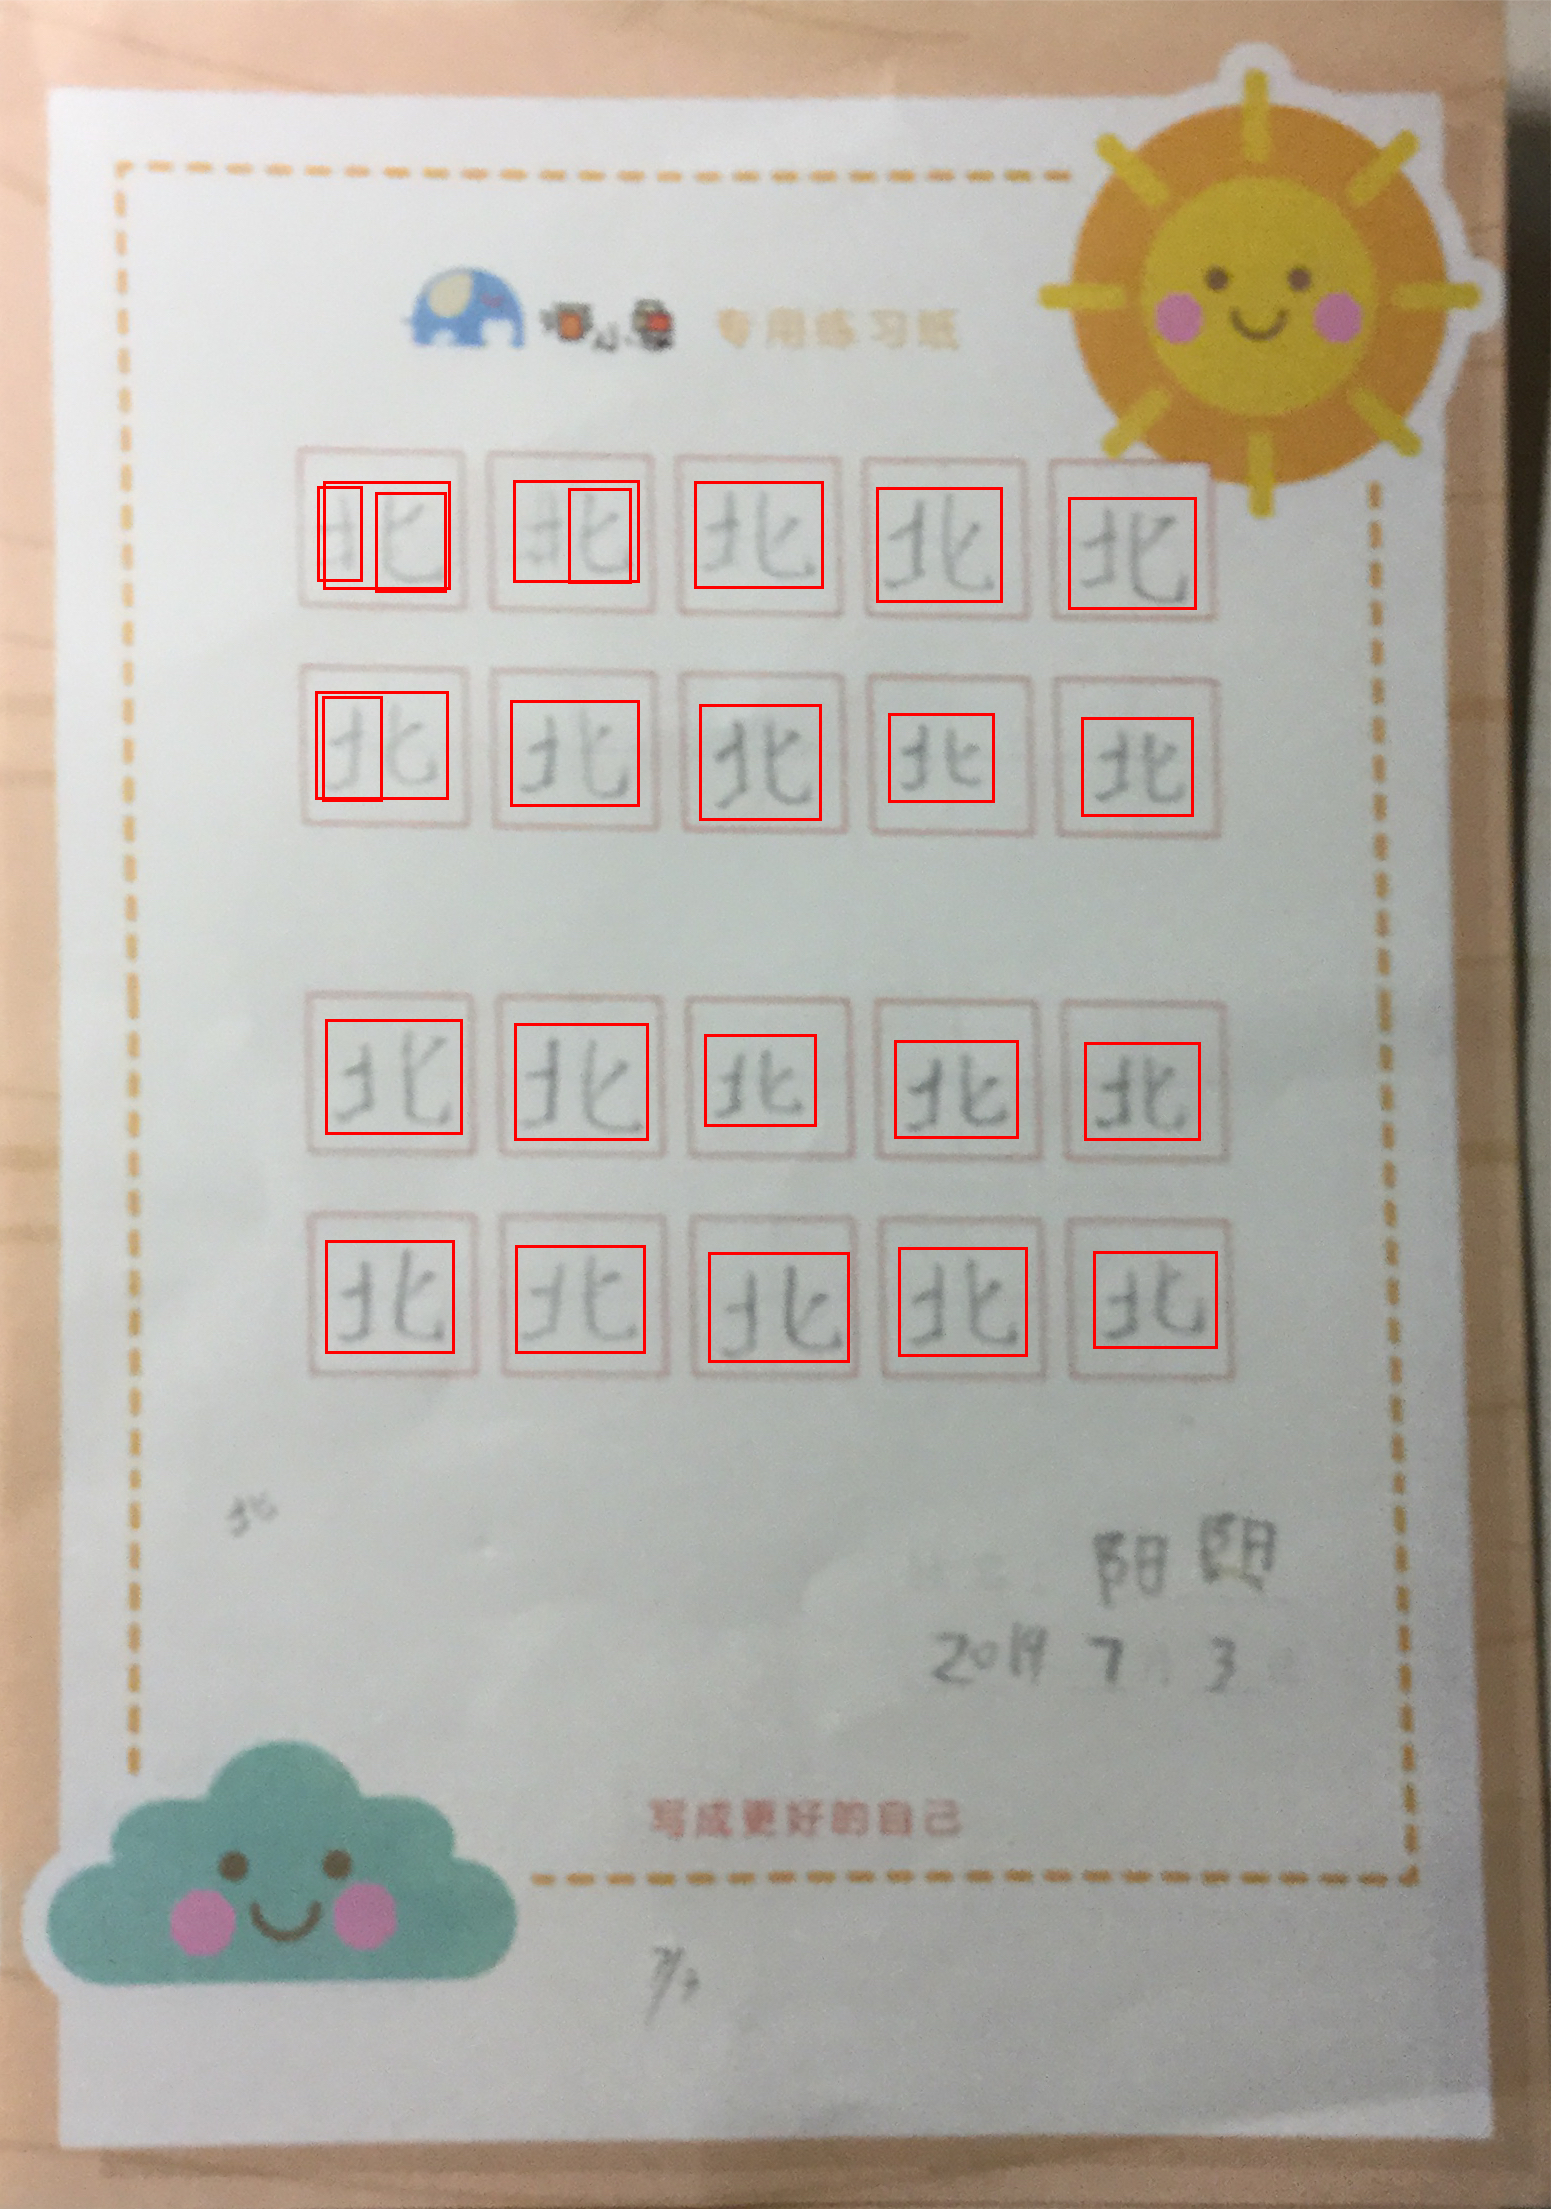

In [36]:
from PIL import Image, ImageDraw
selected_boxes = prediction[0]["boxes"]
selected_scores = prediction[0]["scores"]
img = Image.fromarray(image.mul(255).permute(1, 2, 0).byte().numpy())
draw = ImageDraw.Draw(img)
#draw predictions:
for i in range(len(selected_scores)):
  draw.rectangle([(selected_boxes[i][0], selected_boxes[i][1]), (selected_boxes[i][2],  selected_boxes[i][3])],  outline ="red",  width = 3)
  draw.text((selected_boxes[i][1]*img.width, selected_boxes[i][0]*img.height), text = str(selected_scores[i]))
# draw groundtruth:
# 0ec93009-c6fe-4d9c-ae25-c1a8d9d2a1c
# for i in range(len(true_labels["xmin"].values)):
#   draw.rectangle([(true_labels["xmin"].values[i], true_labels["ymin"].values[i]), (true_labels["xmax"].values[i], true_labels["ymax"].values[i])],  outline ="green",  width = 3)
img